In [1]:
!pip uninstall --yes gdown # After running this line, restart Colab runtime.

Found existing installation: gdown 4.6.6
Uninstalling gdown-4.6.6:
  Successfully uninstalled gdown-4.6.6


In [2]:
!pip install gdown -U --no-cache-dir

In [3]:
import gdown

url = 'https://drive.google.com/drive/folders/1Z7R1g3CJjXe8NVXN7FLzyW6Mx5Vbrp-s?usp=sharing'

gdown.download_folder(url)

Retrieving folder list


Processing file 1Negfad4d2T2qItcuTELTvCk3T8E6gbgL Dig-MNIST.csv
Processing file 1ga4Xk7DJO_kuL6rTyPTEvTA6VnYsvMmp test.csv
Processing file 1JYE626LB8XETG-1So8P2Hw65HaFMNVAI train.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1Negfad4d2T2qItcuTELTvCk3T8E6gbgL
To: /content/kanada/Dig-MNIST.csv
100%|██████████| 18.4M/18.4M [00:00<00:00, 65.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ga4Xk7DJO_kuL6rTyPTEvTA6VnYsvMmp
To: /content/kanada/test.csv
100%|██████████| 8.67M/8.67M [00:00<00:00, 40.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JYE626LB8XETG-1So8P2Hw65HaFMNVAI
To: /content/kanada/train.csv
100%|██████████| 105M/105M [00:02<00:00, 47.2MB/s] 
Download completed


['/content/kanada/Dig-MNIST.csv',
 '/content/kanada/test.csv',
 '/content/kanada/train.csv']

In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [5]:
class KanadaMNIST(Dataset):
  def __init__(self,csv,transform=None,target_transform=None):
    self.data=pd.read_csv(csv)
    self.img_labels=self.data.iloc[:,0]
    self.img=self.data.iloc[:,1:]
    self.transform=transform
    self.target=target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self,idx):
    image=self.img.iloc[idx,:].values.reshape(28,28)
    #image=pixel_val.reshape((28,28))
    label=self.img_labels.iloc[idx]
    if self.transform:
      image=self.transform(image)
    if self.target:
      label=self.target(label)
    return image,label

In [6]:
train_data=KanadaMNIST("/content/kanada/train.csv")
valid_data=KanadaMNIST("/content/kanada/Dig-MNIST.csv")

In [7]:
batch_size=64
train = DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid = DataLoader(valid_data,batch_size=batch_size,shuffle=True)

In [8]:
next(iter(train))[0].shape

torch.Size([64, 28, 28])

Feature batch shape: torch.Size([64, 28, 28])
Labels batch shape: torch.Size([64])


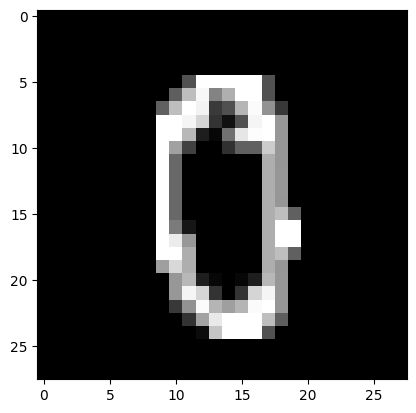

Label: 0


In [9]:
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Reshape the feature tensor to 2D (28x28)
img = np.array(train_features[0])

label = train_labels[0].item()  # Convert tensor to Python scalar
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [10]:
class KanadaCNNnet(nn.Module):
  def __init__(self):
    super(KanadaCNNnet,self).__init__()
    self.conv1=nn.Sequential(
        nn.Conv2d(1,28,5,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        #nn.BatchNorm2d(num_features=10)
    )
    self.conv2=nn.Sequential(
        nn.Conv2d(28,16,5,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        #nn.BatchNorm2d(num_features=10)
    )
    self.fc1=nn.Sequential(
        nn.Flatten(),
        nn.Linear(256,1024),
        nn.Linear(1024,10)
    )
  def forward(self,x):
      x=x.float()
      x=self.conv1(x)

      x=self.conv2(x)
      x=self.fc1(x)
      return x

In [11]:
lr = 1e-4
num_epochs = 10

In [12]:
device=("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model=KanadaCNNnet()
model.to(device)

KanadaCNNnet(
  (conv1): Sequential(
    (0): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(28, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [14]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=lr)

In [15]:
for epochs in range(num_epochs):
  running_loss = 0.0
  num_correct = 0
  for inputs, labels in train:
    inputs=inputs.unsqueeze(dim=1)
    optimizer.zero_grad()
    outputs = model(inputs.to(device))
    labels=labels.to(device)
    loss=loss_fn(outputs,labels)
    loss.backward()
    running_loss+=loss.item()
    optimizer.step()
    _, idx = outputs.max(dim=1)
    num_correct += (idx == labels).sum().item()
  print('Loss: {} Accuracy: {}'.format(running_loss/len(train),num_correct/len(train)))


Loss: 0.48976041546174837 Accuracy: 55.75692963752665
Loss: 0.15896696221135032 Accuracy: 60.86460554371002
Loss: 0.11929216905971611 Accuracy: 61.67910447761194
Loss: 0.09944525145258365 Accuracy: 62.0863539445629
Loss: 0.086105606638328 Accuracy: 62.3134328358209
Loss: 0.07671457489799541 Accuracy: 62.47974413646055
Loss: 0.0692886377392865 Accuracy: 62.637526652452024
Loss: 0.06386309643901551 Accuracy: 62.72921108742004
Loss: 0.05921947545206138 Accuracy: 62.795309168443495
Loss: 0.05509950297024312 Accuracy: 62.93603411513859
